# Glovo Interview Ricardo Huarte

In [5597]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from fancyimpute import KNN    
from sklearn.model_selection import train_test_split,cross_val_score, KFold, StratifiedKFold ,GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler,OneHotEncoder, LabelEncoder, Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,confusion_matrix, classification_report, auc, roc_curve, precision_recall_curve, \
average_precision_score,make_scorer,recall_score, accuracy_score, precision_score
from sklearn import svm
from xgboost.sklearn import XGBClassifier  
from xgboost.sklearn import XGBRegressor
import warnings; warnings.simplefilter('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline

## About Data Set:
You will find 2 .csv files attached to this task. 1 of the files consist of courier’s lifetime dependent features and other consist courier’s weekly variant features. Features are renamed for confidentiality purposes and data dictionary will NOT be provided. However, in 2 different .csv files, same courier ID represents same courier.

## Task 1: Exploratory Analysis and Data Munging

In this task, you are being expected to clean data, treat missing values, find out related features and finally label the data.
Every courier did not work every week. Thus, some of courier-week combinations’ data are not provided. First, come up with a way to treat these missing values. Removing missing values are not suggested since provided data set is small and it will affect your predictive model’s evaluation metric.
Create a report / dashboard and correlation matrix, in addition to results of your univariate and bivariate analysis and explain your findings.
Finally, label your data. If a specific courier’s week 9, 10 and 11 data is not provided, we label this courier as “1” otherwise “0”. After labeling, remove week 8(Yes including 8!), 9, 10 and 11 data to avoid bias in your next task. In addition, distribution of feature_3 is a hint how the data is generated.

In [5598]:
%matplotlib inline

In [5599]:
weekly = pd.read_csv(filepath_or_buffer='Courier_weekly_data.csv')

### Checking how many couriers worked on the given weeks

In [5600]:
weekly[(weekly.week==11) | (weekly.week==10) | (weekly.week==9)]['courier'].drop_duplicates().count()

387

In [5601]:
weeks=weekly.copy()

In [5602]:
# function to create the label for the pertinent weeks
def week_label(row):
    courier_set=weekly[(weekly.courier==row['courier']) & ((weekly.week==9) | (weekly.week==10) |(weekly.week==11))]
    if courier_set['courier'].count() == 0:
        label=1
    else: 
        label=0
    return label

In [5603]:
weeks['label']=weeks.apply(week_label, axis=1)
# keeping only given weeks for prediction
weeks=weeks[(weeks.week<8)]
weeks.head(5)

,courier,week,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,label
0,3767,2,6,34,38,0.0789,0.9211,140.4737,0.1316,2162.4737,0.7632,7.340776,8,20.208158,5.236316,0.8158,43.384804,1,19,1
1,3767,4,-1,42,37,0.0000,1.0000,135.5946,0.0811,2097.4054,0.9459,11.883784,19,18.855405,5.689459,0.8919,35.078042,3,11,1
2,3767,5,24,41,43,0.0233,0.9767,131.0930,0.0233,2043.8837,0.9302,7.072100,16,18.925116,5.138605,0.9302,31.455285,1,10,1
3,3767,6,-22,65,66,0.0606,0.9394,120.1515,0.0000,2124.2727,0.7727,7.356567,33,18.259697,4.704394,0.7879,34.252991,1,30,1
4,6282,2,9,33,27,0.0741,0.9259,100.0000,0.0370,4075.7407,0.8889,8.501233,5,26.863704,4.828519,0.8889,46.478114,1,4,0


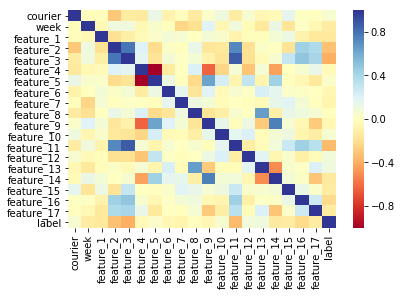

In [5604]:
week_corr=weeks.corr()
sns.heatmap(week_corr, vmax=1., square=False,cmap="RdYlBu")

(array([398., 596., 676., 608., 383., 226.,  89.,  34.,   9.,   6.]),
 array([  1. ,  19.3,  37.6,  55.9,  74.2,  92.5, 110.8, 129.1, 147.4,
        165.7, 184. ]),
 <a list of 10 Patch objects>)

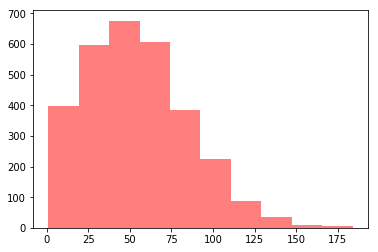

In [5605]:
plt.hist(weeks.feature_3,alpha=0.5,color='red')

Text(0.5,1,'churned')

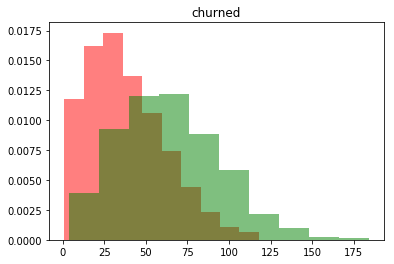

In [5606]:
#normalize histogram
plt.hist(weeks[(weeks.label==1)].feature_3,alpha=0.5,color='red',density=1)
plt.hist(weeks[(weeks.label==0)].feature_3,alpha=0.5,color='green',density=1)
plt.title('churned')

In [5607]:
# creating some functions for new features
def max_consecutive(vector):
    longest = 0
    current = 0
    for num in vector:
        if num == 1:
            current += 1
        else:
            longest = max(longest, current)
            current = 0

    return max(longest, current)
def latest_streak(series):
    week_vector=[0,0,0,0,0,0,0,0]
    count=0
    
    for i in series:
        week_vector[i]=1
    reversed_week=list(reversed(week_vector))
    for i in reversed_week:
        if i==1:
            count+=1
        else: 
            break
    return count
def max_streak(series):
    week_vector=[0,0,0,0,0,0,0,0]
    
    for i in series:
        week_vector[i]=1
    streak=max_consecutive(week_vector)
    return streak
def get_range(series):
    return max(series)-min(series)
def lifetime_mean(series):
    return np.sum(series)/8


In [5608]:
max_consecutive([0,1,1,1,0,0,1,0,1,1,1,1,1,1,0])

6

# About dealing with the sparse week information
### In order to have a dataset in the form of a vector per courier, I try with different aggregation methods along with defined new features that will give us information about the time sparsity
### Week Count is just the amount of weeks that the courier worked
### Week Max Streak is the number of maximum weeks in a row a courier worked
### Week latest streak is the maximum number of weeks worked towards the end of the period, meaning from the 7th week backwards

### Although for some features we apparently have integers instead of doubles, we will take the mean or the lifetime average (in this one we take the sum and divide by all 8 weeks), if data dictionary was provided then would be easier to choose how to deal with such features, otherwise, we will treat them the same

## trying different aggregation methods on the data

In [6098]:
aggreg=get_range
aggreg='mean'
#aggreg=lifetime_mean
aggregname='mean'

In [6099]:
gold=weeks.groupby(['courier','label'], as_index=False )\
.agg({'week':['count',  max_streak,latest_streak],\
              'feature_1':aggreg,\
               'feature_2':aggreg,'feature_3':aggreg\
      ,'feature_4':aggreg,'feature_5':aggreg\
      ,'feature_6':aggreg,'feature_7':aggreg\
      ,'feature_8':aggreg,'feature_9':aggreg\
      ,'feature_10':aggreg,'feature_11':aggreg\
     ,'feature_12':aggreg,'feature_13':aggreg\
     ,'feature_14':aggreg,'feature_15':aggreg\
     ,'feature_16':aggreg,'feature_17':aggreg})

In [6100]:
gold[(gold.courier==6282)]

courier label  week                          feature_1  feature_2 feature_3  \
                count max_streak latest_streak      mean       mean      mean   
1    6282     0     6          6             6  1.333333  36.666667      48.5   

  feature_4 feature_5    ...       feature_8 feature_9 feature_10 feature_11  \
       mean      mean    ...            mean      mean       mean       mean   
1  0.075517  0.924483    ...      4300.18395  0.881117   8.317717       13.0   

  feature_12 feature_13 feature_14 feature_15 feature_16 feature_17  
        mean       mean       mean       mean       mean       mean  
1  21.595879   5.379692    0.88055  72.957087        1.5   6.166667  

[1 rows x 22 columns]

In [6101]:
gold.columns = [gold + i for gold, i in zip(gold.columns.get_level_values(0), gold.columns.get_level_values(1).astype(str))]
golden_names=[w.replace(aggregname,'') for w in gold.columns.get_level_values(0)]
gold.columns = golden_names
gold=gold.rename(columns={'label':'y'})
gold.set_index('courier', inplace=True)

In [6102]:
#gold.columns = [gold  for gold in gold.columns.get_level_values(0)]

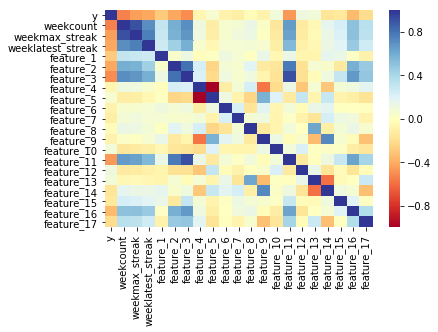

In [6103]:
gold_corr=gold.corr()
sns.heatmap(gold_corr, vmax=1., square=False,cmap="RdYlBu")

In [6104]:
gold.head(3)

,y,weekcount,weekmax_streak,weeklatest_streak,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17
courier,,,,,,,,,,,,,,,,,,,,,
3767,1,4,3,0,1.750000,45.500000,46.0,0.040700,0.959300,131.82820,...,2107.008875,0.853000,8.413307,19.0,19.062094,5.192193,0.85645,36.042781,1.5,17.500000
6282,0,6,6,6,1.333333,36.666667,48.5,0.075517,0.924483,111.29100,...,4300.183950,0.881117,8.317717,13.0,21.595879,5.379692,0.88055,72.957087,1.5,6.166667
10622,1,2,2,0,-3.500000,84.500000,54.0,0.119050,0.880950,100.15875,...,2576.890500,0.623800,10.199895,20.5,21.568016,4.179873,0.66030,35.646190,2.5,15.500000


Text(0.5,1,'churned')

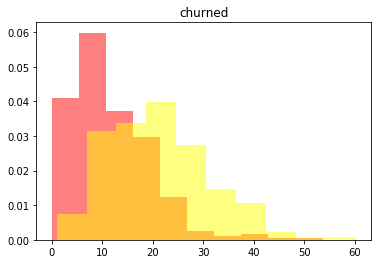

In [6105]:
plt.hist(gold[(gold.y==1)].feature_11,alpha=0.5,color='red',density=1)
plt.hist(gold[(gold.y==0)].feature_11,alpha=0.5,color='yellow',density=1)
plt.title('churned')

plt.hist(gold[(gold.y==1)].weekmax_streak,alpha=0.5,color='red',density=1)
plt.hist(gold[(gold.y==0)].weekmax_streak,alpha=0.5,color='yellow',density=1)
plt.title('churned')

#### There seems to be a difference between the distribution  of feature 2. 3. and 11 per class

In [6106]:
gold.head()

,y,weekcount,weekmax_streak,weeklatest_streak,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17
courier,,,,,,,,,,,,,,,,,,,,,
3767,1,4,3,0,1.750000,45.500000,46.000,0.040700,0.959300,131.82820,...,2107.008875,0.853000,8.413307,19.000,19.062094,5.192193,0.856450,36.042781,1.5,17.500000
6282,0,6,6,6,1.333333,36.666667,48.500,0.075517,0.924483,111.29100,...,4300.183950,0.881117,8.317717,13.000,21.595879,5.379692,0.880550,72.957087,1.5,6.166667
10622,1,2,2,0,-3.500000,84.500000,54.000,0.119050,0.880950,100.15875,...,2576.890500,0.623800,10.199895,20.500,21.568016,4.179873,0.660300,35.646190,2.5,15.500000
13096,0,2,2,0,0.000000,59.000000,89.500,0.161600,0.838400,104.29600,...,4590.275250,0.686000,9.630672,34.500,17.902412,5.166684,0.720300,84.347978,3.0,19.000000
14261,1,8,8,8,-3.625000,75.500000,70.875,0.018425,0.981575,115.62990,...,3870.750225,0.892537,10.001638,34.875,21.166889,5.433909,0.900662,49.311612,2.5,6.750000


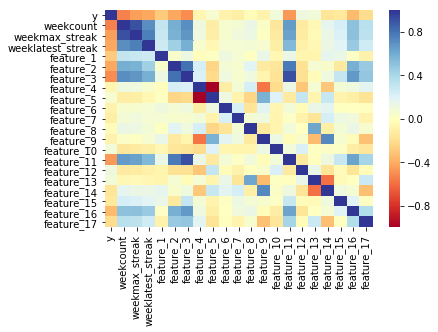

In [6107]:
sns.heatmap(gold_corr, vmax=1., square=False,cmap="RdYlBu")

In [6108]:
#sns.pairplot(gold, hue='y')

In [6109]:
#gold=gold[['y','weekcount','weekmax_streak','weeklatest_streak','feature_5','feature_6','feature_9','feature_10','feature_12','feature_13','feature_14','feature_15']]

In [6110]:
gold=gold[['y','weekcount','weekmax_streak','weeklatest_streak','feature_1','feature_2','feature_3','feature_11','feature_16']]

In [6111]:
# After running several test with multiple features and after having almost the same accuracy and after looking at the distribution of the features per class and looking at the feature correlation I chose to go with feature 2 and 3 

In [6112]:
#gold=gold[['y','weekcount','weekmax_streak','weeklatest_streak','feature_3','feature_2']]

## Bringing lifetime info into the mix

In [6113]:
#adding lifetime info
lifetime = pd.read_csv(filepath_or_buffer='Courier_lifetime_data.csv')


In [6114]:
lifetime.head()

,courier,feature_1,feature_2
0,208,a,25.0
1,218,c,0.0
2,225,c,NaN
3,231,c,0.0
4,242,c,NaN


In [6115]:
lifetime.rename(columns={'feature_1':'lifetime_feature_1','feature_2':'lifetime_feature_2'}, inplace=True)

In [6116]:
gen_le = LabelEncoder()
gen_labels = gen_le.fit_transform(lifetime['lifetime_feature_1'])
lifetime['lifetime_feature_1'] = gen_labels

In [6117]:
lifetime_encoded= pd.get_dummies(lifetime, columns=['lifetime_feature_1'])

In [6118]:
#lifetime_encoded=lifetime.copy()

In [6119]:
lifetime_encoded.set_index('courier', inplace=True)

In [6120]:
lifetime_encoded.head()

,lifetime_feature_2,lifetime_feature_1_0,lifetime_feature_1_1,lifetime_feature_1_2,lifetime_feature_1_3
courier,,,,,
208,25.0,1,0,0,0
218,0.0,0,0,1,0
225,NaN,0,0,1,0
231,0.0,0,0,1,0
242,NaN,0,0,1,0


In [6121]:
#lifetime_encoded=lifetime_encoded.drop('feature_2', axis=1)

In [6122]:
gold=gold.merge(lifetime_encoded, how='left', left_index=True, right_index=True)


In [6123]:
gold.head()

,y,weekcount,weekmax_streak,weeklatest_streak,feature_1,feature_2,feature_3,feature_11,feature_16,lifetime_feature_2,lifetime_feature_1_0,lifetime_feature_1_1,lifetime_feature_1_2,lifetime_feature_1_3
courier,,,,,,,,,,,,,,
3767,1,4,3,0,1.750000,45.500000,46.000,19.000,1.5,33.0,0,1,0,0
6282,0,6,6,6,1.333333,36.666667,48.500,13.000,1.5,35.0,1,0,0,0
10622,1,2,2,0,-3.500000,84.500000,54.000,20.500,2.5,35.0,0,1,0,0
13096,0,2,2,0,0.000000,59.000000,89.500,34.500,3.0,35.0,1,0,0,0
14261,1,8,8,8,-3.625000,75.500000,70.875,34.875,2.5,44.0,1,0,0,0


### Using the selected features to impute the missing values from lifetime with KNN imputation 

In [6124]:
#gold =  pd.DataFrame(KNN(k=2).fit_transform(gold), columns=gold.columns, index=gold.index) 

In [6125]:
gold.head()

,y,weekcount,weekmax_streak,weeklatest_streak,feature_1,feature_2,feature_3,feature_11,feature_16,lifetime_feature_2,lifetime_feature_1_0,lifetime_feature_1_1,lifetime_feature_1_2,lifetime_feature_1_3
courier,,,,,,,,,,,,,,
3767,1,4,3,0,1.750000,45.500000,46.000,19.000,1.5,33.0,0,1,0,0
6282,0,6,6,6,1.333333,36.666667,48.500,13.000,1.5,35.0,1,0,0,0
10622,1,2,2,0,-3.500000,84.500000,54.000,20.500,2.5,35.0,0,1,0,0
13096,0,2,2,0,0.000000,59.000000,89.500,34.500,3.0,35.0,1,0,0,0
14261,1,8,8,8,-3.625000,75.500000,70.875,34.875,2.5,44.0,1,0,0,0


In [6126]:
gold_mt=gold.corr()
gold_mt

,y,weekcount,weekmax_streak,weeklatest_streak,feature_1,feature_2,feature_3,feature_11,feature_16,lifetime_feature_2,lifetime_feature_1_0,lifetime_feature_1_1,lifetime_feature_1_2,lifetime_feature_1_3
y,1.000000,-0.534864,-0.442932,-0.415129,-0.287069,-0.420368,-0.502446,-0.464239,-0.346133,-0.200355,-0.153103,0.175943,0.052522,-0.053252
weekcount,-0.534864,1.000000,0.912668,0.706565,0.308786,0.590266,0.707429,0.660209,0.504314,0.242526,0.206490,-0.252722,-0.025867,0.094180
weekmax_streak,-0.442932,0.912668,1.000000,0.758359,0.291029,0.570816,0.686554,0.640439,0.514343,0.227177,0.191525,-0.228066,-0.041832,0.078020
weeklatest_streak,-0.415129,0.706565,0.758359,1.000000,0.267561,0.440527,0.582624,0.539818,0.462136,0.188627,0.195845,-0.215066,-0.032577,0.039158
feature_1,-0.287069,0.308786,0.291029,0.267561,1.000000,0.042441,0.121433,0.136845,0.015898,0.150614,0.082449,-0.124961,-0.018950,0.090340
feature_2,-0.420368,0.590266,0.570816,0.440527,0.042441,1.000000,0.809809,0.779639,0.580537,0.180502,0.216367,-0.236613,-0.012582,0.035859
feature_3,-0.502446,0.707429,0.686554,0.582624,0.121433,0.809809,1.000000,0.920134,0.666711,0.241822,0.261974,-0.267140,-0.023151,0.004369
feature_11,-0.464239,0.660209,0.640439,0.539818,0.136845,0.779639,0.920134,1.000000,0.625702,0.257226,0.216313,-0.234803,-0.026124,0.035228
feature_16,-0.346133,0.504314,0.514343,0.462136,0.015898,0.580537,0.666711,0.625702,1.000000,0.135372,0.174378,-0.194260,-0.046458,0.044673
lifetime_feature_2,-0.200355,0.242526,0.227177,0.188627,0.150614,0.180502,0.241822,0.257226,0.135372,1.000000,0.172418,-0.234322,-0.013384,0.134673


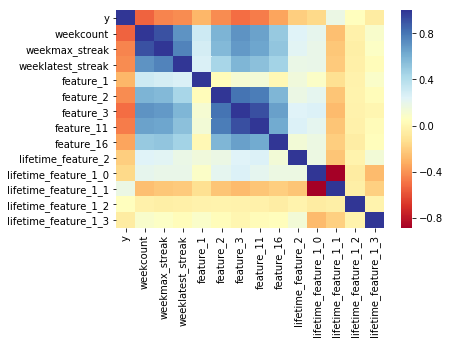

In [6127]:
sns.heatmap(gold_mt, vmax=1., square=False,cmap="RdYlBu")

In [6128]:
#gold=gold.drop('feature_1',axis=1)

# We prepare the golden set

In [6129]:
golden_x= gold.drop(['y'], axis=1)
golden_y= gold['y']

In [6130]:
#golden_x =  pd.DataFrame(KNN(k=2).fit_transform(golden_x), columns=golden_x.columns, index=golden_x.index) 

In [6131]:
golden_x_mt=golden_x.corr()
golden_x_mt

,weekcount,weekmax_streak,weeklatest_streak,feature_1,feature_2,feature_3,feature_11,feature_16,lifetime_feature_2,lifetime_feature_1_0,lifetime_feature_1_1,lifetime_feature_1_2,lifetime_feature_1_3
weekcount,1.000000,0.912668,0.706565,0.308786,0.590266,0.707429,0.660209,0.504314,0.242526,0.206490,-0.252722,-0.025867,0.094180
weekmax_streak,0.912668,1.000000,0.758359,0.291029,0.570816,0.686554,0.640439,0.514343,0.227177,0.191525,-0.228066,-0.041832,0.078020
weeklatest_streak,0.706565,0.758359,1.000000,0.267561,0.440527,0.582624,0.539818,0.462136,0.188627,0.195845,-0.215066,-0.032577,0.039158
feature_1,0.308786,0.291029,0.267561,1.000000,0.042441,0.121433,0.136845,0.015898,0.150614,0.082449,-0.124961,-0.018950,0.090340
feature_2,0.590266,0.570816,0.440527,0.042441,1.000000,0.809809,0.779639,0.580537,0.180502,0.216367,-0.236613,-0.012582,0.035859
feature_3,0.707429,0.686554,0.582624,0.121433,0.809809,1.000000,0.920134,0.666711,0.241822,0.261974,-0.267140,-0.023151,0.004369
feature_11,0.660209,0.640439,0.539818,0.136845,0.779639,0.920134,1.000000,0.625702,0.257226,0.216313,-0.234803,-0.026124,0.035228
feature_16,0.504314,0.514343,0.462136,0.015898,0.580537,0.666711,0.625702,1.000000,0.135372,0.174378,-0.194260,-0.046458,0.044673
lifetime_feature_2,0.242526,0.227177,0.188627,0.150614,0.180502,0.241822,0.257226,0.135372,1.000000,0.172418,-0.234322,-0.013384,0.134673
lifetime_feature_1_0,0.206490,0.191525,0.195845,0.082449,0.216367,0.261974,0.216313,0.174378,0.172418,1.000000,-0.885355,-0.058804,-0.273690


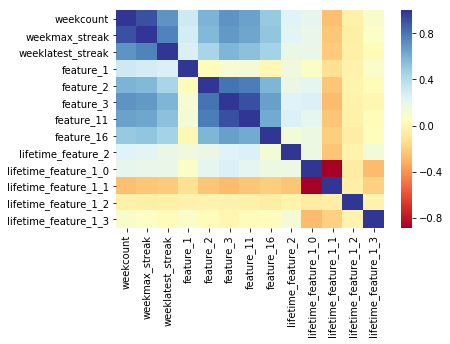

In [6206]:
sns.heatmap(golden_x_mt, vmax=1., square=False,cmap="RdYlBu")

In [6207]:
x_train, x_test, y_train, y_test = train_test_split(golden_x,golden_y , test_size=0.25,stratify=golden_y)
#stratified train test split to have balanced classes in training and testing sets

# About imputing missing values
### I use KNN to impute missing values for lifetime dataset feature_2, I do it separately in the testing and training set, I do so to prevent data leakage altough may come with a cost on the accuracy of the imputation 

In [6208]:
x_train =  pd.DataFrame(KNN(k=2).fit_transform(x_train), columns=x_train.columns, index=x_train.index) 
x_test =  pd.DataFrame(KNN(k=2).fit_transform(x_test), columns=x_test.columns, index=x_test.index) 

Imputing row 1/546 with 0 missing, elapsed time: 0.053
Imputing row 101/546 with 1 missing, elapsed time: 0.054
Imputing row 201/546 with 0 missing, elapsed time: 0.055
Imputing row 301/546 with 1 missing, elapsed time: 0.055
Imputing row 401/546 with 0 missing, elapsed time: 0.056
Imputing row 501/546 with 0 missing, elapsed time: 0.056
Imputing row 1/183 with 0 missing, elapsed time: 0.007
Imputing row 101/183 with 0 missing, elapsed time: 0.008


In [6209]:
scaler=StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Building model for prediction

In [6210]:
y_train.value_counts()

1    273
0    273
Name: y, dtype: int64

In [6211]:
y_test.value_counts()

0    92
1    91
Name: y, dtype: int64

### Although the classes are balanced, still the amount of data is small we'll use Logistic regression and random forest to try to compensate for the size of the sample set

### I display metrics like ROC and PR Curve but we will try to optimize accuracy since we have balanced classes

## LogisticRegression

Accuracy of logistic regression classifier on test set: 0.79
             precision    recall  f1-score   support

          0       0.78      0.80      0.79        92
          1       0.80      0.77      0.78        91

avg / total       0.79      0.79      0.79       183



Text(0.5,15,'Predicted label')

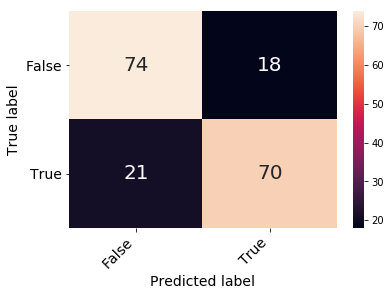

In [6212]:
clf = LogisticRegression(C=0.1, penalty='l1', class_weight='balanced')
clf.fit(x_train, y_train)
test_y_pred = clf.predict(x_test)
cf_mt = confusion_matrix(y_test, test_y_pred)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf.score(x_test, y_test)))
print(classification_report(y_test, test_y_pred))
confusion_matrix_df = pd.DataFrame(cf_mt, ('False', 'True'), ('False', 'True'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

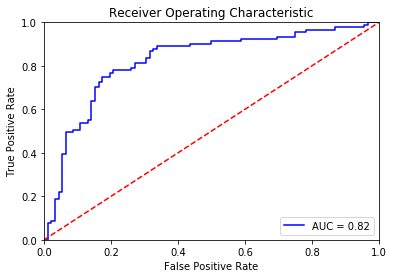

In [6213]:
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.78')

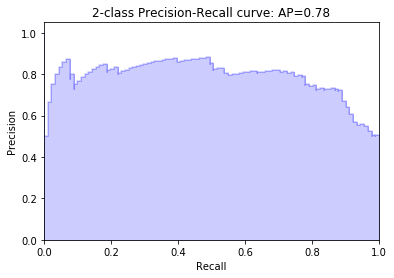

In [6214]:
average_precision = average_precision_score(y_test, preds)
precision, recall, _ = precision_recall_curve(y_test, preds)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,  color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format( average_precision))

# Logistic regression grid search

In [6215]:
grid={"C":[0.001, 0.01, 0.1, 1, 10, 100, 1000] , "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(class_weight='balanced')
logreg_cv=GridSearchCV(logreg,grid,cv=2)
logreg_cv.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10, 'penalty': 'l2'}
accuracy : 0.7490842490842491


Accuracy of logistic regression classifier on test set: 0.78
             precision    recall  f1-score   support

          0       0.76      0.80      0.78        92
          1       0.79      0.75      0.77        91

avg / total       0.78      0.78      0.78       183



Text(0.5,15,'Predicted label')

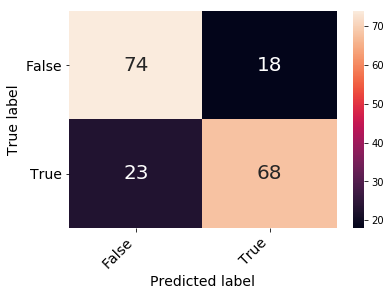

In [6216]:
test_y_pred = logreg_cv.predict(x_test)
cf_mt = confusion_matrix(y_test, test_y_pred)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_cv.score(x_test, y_test)))
print(classification_report(y_test, test_y_pred))
confusion_matrix_df = pd.DataFrame(cf_mt, ('False', 'True'), ('False', 'True'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

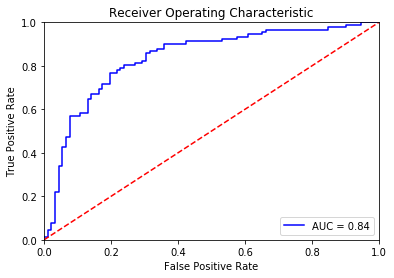

In [6217]:
probs = logreg_cv.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.80')

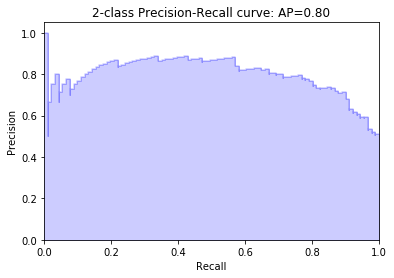

In [6218]:
average_precision = average_precision_score(y_test, preds)
precision, recall, _ = precision_recall_curve(y_test, preds)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

# Logistic cross validation score

Accuracy: 0.747 (0.018)


Text(0.5,15,'Predicted label')

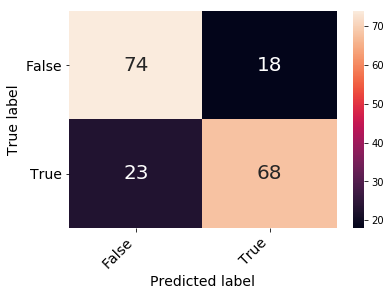

In [6219]:
logreg_cv.fit(x_train,y_train)
seed = 7
k_fold = KFold(n_splits=5, random_state=seed)
scoring = 'accuracy'
results=cross_val_score(logreg_cv, x_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print("Accuracy: %.3f (%.3f)" % (results.mean(), results.std()))
predicted=logreg_cv.predict(x_test)
matrix = confusion_matrix(y_test, predicted)
confusion_matrix_df = pd.DataFrame(matrix, ('False', 'True'), ('False', 'True'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

# Adaboost

Accuracy: 0.720 (0.020)
0.7923497267759563


Text(0.5,15,'Predicted label')

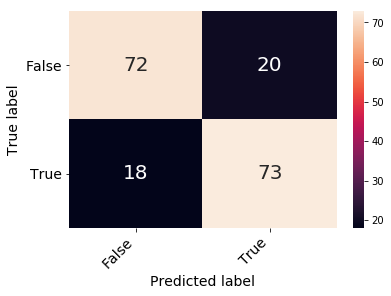

In [6220]:
clf = AdaBoostClassifier(n_estimators=50,learning_rate=0.01,algorithm='SAMME')
clf.fit(x_train,y_train)

seed = 7
k_fold = KFold(n_splits=2)
scoring = 'accuracy'
results=cross_val_score(clf, x_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print("Accuracy: %.3f (%.3f)" % (results.mean(), results.std()))
print(clf.score(x_test, y_test))
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
matrix = confusion_matrix(y_test, predicted)
confusion_matrix_df = pd.DataFrame(matrix, ('False', 'True'), ('False', 'True'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

In [6221]:
param_dist = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1,10],
 'algorithm' : ['SAMME', 'SAMME.R']
 }
ada_tuned = GridSearchCV(AdaBoostClassifier(),
param_dist,
 cv=2,
 
 n_jobs=-1)

ada_tuned.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",ada_tuned.best_params_)
print("accuracy :",ada_tuned.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'SAMME', 'learning_rate': 0.3, 'n_estimators': 50}
accuracy : 0.7619047619047619


Accuracy of logistic regression classifier on test set: 0.74
             precision    recall  f1-score   support

          0       0.73      0.78      0.75        92
          1       0.76      0.70      0.73        91

avg / total       0.74      0.74      0.74       183



Text(0.5,15,'Predicted label')

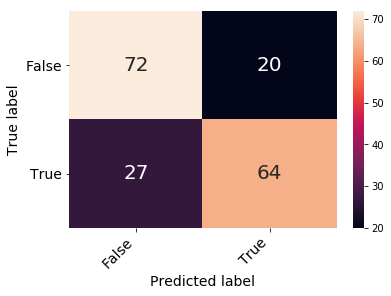

In [6222]:
test_y_pred = ada_tuned.predict(x_test)
cf_mt = confusion_matrix(y_test, test_y_pred)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(ada_tuned.score(x_test, y_test)))
print(classification_report(y_test, test_y_pred))
confusion_matrix_df = pd.DataFrame(cf_mt, ('False', 'True'), ('False', 'True'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

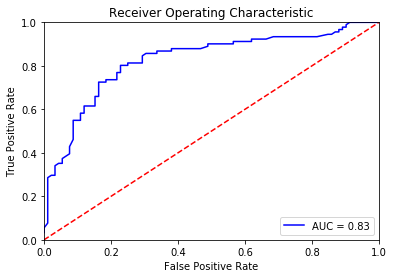

In [6223]:
probs = ada_tuned.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# SVC

In [6224]:
param_dist =  [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
svc_grid = GridSearchCV(svm.SVC(),  param_dist,cv=2)
svc_grid.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",svc_grid.best_params_)
print("accuracy :",svc_grid.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
accuracy : 0.76007326007326


Accuracy of logistic regression classifier on test set: 0.78
             precision    recall  f1-score   support

          0       0.73      0.78      0.75        92
          1       0.76      0.70      0.73        91

avg / total       0.74      0.74      0.74       183

Accuracy: 0.742 (0.013)
[[73 19]
 [22 69]]


Text(0.5,15,'Predicted label')

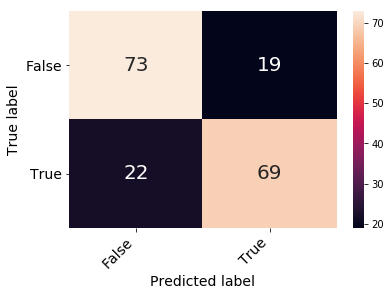

In [6225]:
clf = svm.SVC(C=10,kernel='rbf',probability=True,gamma=0.001)
clf.fit(x_train,y_train)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf.score(x_test, y_test)))
print(classification_report(y_test, test_y_pred))
seed = 7
k_fold = KFold(n_splits=2, random_state=seed)
scoring = 'accuracy'
results=cross_val_score(clf, x_train, y_train, cv=k_fold, scoring=scoring)
print("Accuracy: %.3f (%.3f)" % (results.mean(), results.std()))
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
matrix = confusion_matrix(y_test, predicted)
print(matrix)
confusion_matrix_df = pd.DataFrame(matrix, ('False', 'True'), ('False', 'True'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

             precision    recall  f1-score   support

          0       0.73      0.78      0.75        92
          1       0.76      0.70      0.73        91

avg / total       0.74      0.74      0.74       183



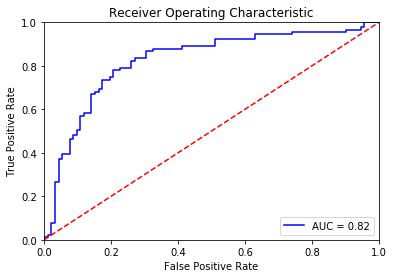

In [6226]:
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print(classification_report(y_test, test_y_pred))
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.79')

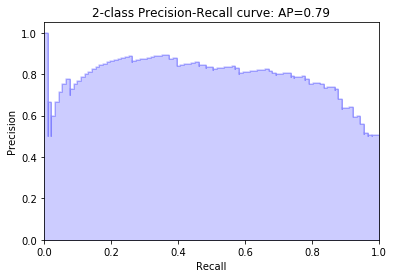

In [6227]:
average_precision = average_precision_score(y_test, preds)
precision, recall, _ = precision_recall_curve(y_test, preds)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

# Random Forest

In [6228]:
randomForest = RandomForestClassifier( max_depth=5, max_features=5, min_samples_split=4, n_estimators=100)
randomForest.fit(x_train, y_train)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(randomForest.score(x_test, y_test)))

Accuracy of random forest classifier on test set: 0.75


Accuracy: 0.747 (0.026)


Text(0.5,15,'Predicted label')

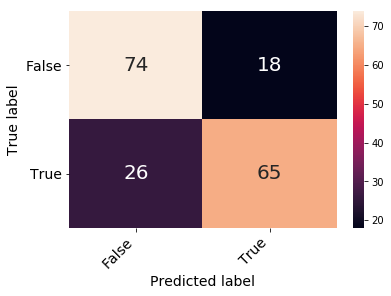

In [6229]:
seed = 7
k_fold = KFold(n_splits=2, random_state=seed)
scoring = 'accuracy'
results = results=cross_val_score(randomForest, x_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print("Accuracy: %.3f (%.3f)" % (results.mean(), results.std()))


randomForest.fit(x_train,y_train)
predicted=randomForest.predict(x_test)
matrix = confusion_matrix(y_test, predicted)

confusion_matrix_df = pd.DataFrame(matrix, ('False', 'True'), ('False', 'True'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

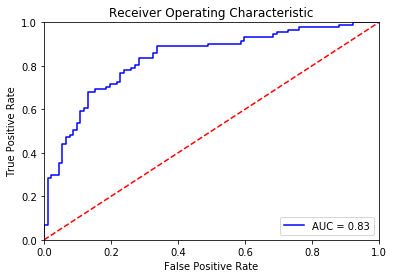

In [6230]:
probs = randomForest.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.83')

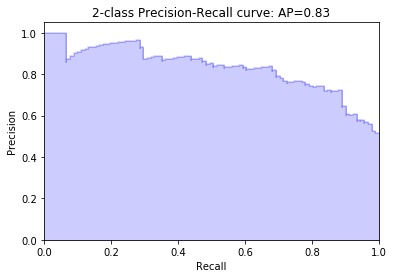

In [6231]:
average_precision = average_precision_score(y_test, preds)
precision, recall, _ = precision_recall_curve(y_test, preds)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

Feature ranking:
1. feature 0 (0.216967)
2. feature 5 (0.206845)
3. feature 3 (0.126011)
4. feature 4 (0.111286)
5. feature 2 (0.101246)
6. feature 6 (0.089397)
7. feature 8 (0.054799)
8. feature 1 (0.043452)
9. feature 7 (0.038773)
10. feature 12 (0.004083)
11. feature 10 (0.003616)
12. feature 9 (0.003525)
13. feature 11 (0.000000)


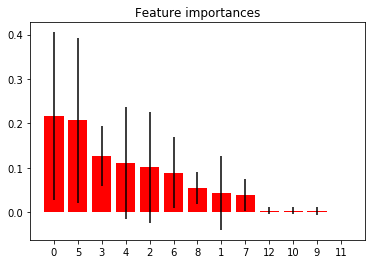

In [6232]:
importances = randomForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomForest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(golden_x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(golden_x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(golden_x.shape[1]), indices)
plt.xlim([-1, golden_x.shape[1]])
plt.show()

In [6233]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 4, 5,8], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5,8]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [6258]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=3)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(x_train, y_train)

    
    y_pred = grid_search.predict(x_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [6259]:
grid_search_clf = grid_search_wrapper(refit_score='accuracy_score')

Best params for accuracy_score
{'max_depth': 5, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for accuracy_score on the test data:
     pred_neg  pred_pos
neg        72        20
pos        25        66


In [6237]:
models = [{    'label': 'Logistic Regression',
    'model': LogisticRegression(),
           'grid': {"C":[0.001, 0.01, 0.1, 1, 10, 100, 1000] , "penalty":["l1","l2"]},
           
},
{    'label': 'RandomForest',
    'model': RandomForestClassifier( ),
 'grid' : {    'min_samples_split': [3, 4, 5,8], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5,8]},
},
{    'label': 'SVC',
    'model': svm.SVC(probability=True),
 'grid':  {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],   'C': [1, 10, 100, 1000]},
},
{    'label': 'Adaboost',
    'model': AdaBoostClassifier(),
 'grid': { 'n_estimators': [50, 100], 'learning_rate' : [0.01,0.05,0.1,0.3,1,10], 'algorithm' : ['SAMME', 'SAMME.R']},
} ]

In [6265]:
models = [{    'label': 'Logistic Regression',
    'model': LogisticRegression(C=10, penalty='l2', class_weight='balanced'),                
},
{    'label': 'RandomForest',
    'model': RandomForestClassifier( max_depth=5, max_features=5, min_samples_split=4, n_estimators=300),
},
{    'label': 'SVC',
    'model': svm.SVC(C=1000,kernel='rbf',probability=True,gamma=0.001),
},
{    'label': 'Adaboost',
    'model': AdaBoostClassifier(n_estimators=50,learning_rate=0.3,algorithm='SAMME'),
} ]

In [6273]:
print('Cross-Validation Score')
for m in models:
    model = m['model'] # select the model
    model.fit(x_train, y_train) # train the model
    
    seed = 7
    k_fold = KFold(n_splits=3, random_state=seed)
    scoring = 'accuracy'
    results=cross_val_score(model, x_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
    print("Accuracy of %s: %.3f (%.3f)" % (m['label'],results.mean(), results.std()))

Cross-Validation Score
Accuracy of Logistic Regression: 0.769 (0.012)
Accuracy of RandomForest: 0.742 (0.013)
Accuracy of SVC: 0.753 (0.013)
Accuracy of Adaboost: 0.758 (0.027)


## The one that performs the best in both the cross-validation and the the score on the tesing set is the Logistic regression

In [6274]:
print('Validation on testing set')
for m in models:
    model = m['model']# select the model
    model.fit(x_train, y_train) # train the model
    test_y_pred = model.predict(x_test)
    cf_mt = confusion_matrix(y_test, test_y_pred)
    print('Accuracy of %s: classifier on test set: %.3f'%(m['label'],model.score(x_test, y_test)))
    print(classification_report(y_test, test_y_pred))

Validation on testing set
Accuracy of Logistic Regression: classifier on test set: 0.776
             precision    recall  f1-score   support

          0       0.76      0.80      0.78        92
          1       0.79      0.75      0.77        91

avg / total       0.78      0.78      0.78       183

Accuracy of RandomForest: classifier on test set: 0.749
             precision    recall  f1-score   support

          0       0.73      0.78      0.76        92
          1       0.76      0.71      0.74        91

avg / total       0.75      0.75      0.75       183

Accuracy of SVC: classifier on test set: 0.765
             precision    recall  f1-score   support

          0       0.76      0.78      0.77        92
          1       0.77      0.75      0.76        91

avg / total       0.77      0.77      0.76       183

Accuracy of Adaboost: classifier on test set: 0.743
             precision    recall  f1-score   support

          0       0.73      0.78      0.75        92
    

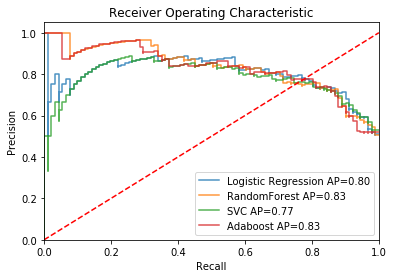

In [6271]:
plt.figure()

# Below for loop iterates through your models list
for m in models:
    model = m['model']# select the model
    model.fit(x_train, y_train) # train the model
    y_pred=model.predict(x_test) # predict the test data
    probs = model.predict_proba(x_test)
    preds = probs[:,1]
    average_precision = average_precision_score(y_test, preds)
    precision, recall, _ = precision_recall_curve(y_test, preds)
    plt.step(recall, precision,  alpha=0.8, where='post',label='%s AP=%0.2f' % (m['label'], average_precision))
    #plt.fill_between(recall, precision, step='post', alpha=0.2)

# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

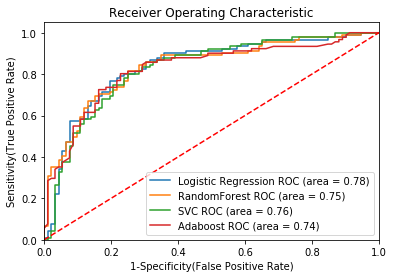

In [6272]:
plt.figure()

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(x_train, y_train) # train the model
    y_pred=model.predict(x_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc_ = roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc_))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display